#Importation des Bibliothèques

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


# Chemins vers Mes datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

base_path = "/content/drive/MyDrive/TB_Dataset"

print("Contenu du dataset :", os.listdir(base_path))
print("Exemple Shenzhen :", os.listdir(os.path.join(base_path, "Shenzhenset"))[:5])


Contenu du dataset : ['Shenzhenset', 'Montgomeryset', 'densenet169_tb.h5', 'best_model_mobilenet.h5', 'best_model_densenet.h5', 'model_vgg16.h5', 'model_mobilenet.h5', 'model_densenet.h5', 'dataset_tb.csv', 'train.csv', 'val.csv', 'test.csv', 'best_model_vgg16.h5']
Exemple Shenzhen : ['CHNCXR_0001_0.png', 'CHNCXR_0002_0.png', 'CHNCXR_0003_0.png', 'CHNCXR_0005_0.png', 'CHNCXR_0004_0.png']


In [ ]:
import glob
import pandas as pd

def load_dataset(folder, label_type):
    images = glob.glob(os.path.join(folder, "*.png"))


    data = []
    for img in images:
        label = 1 if "_1" in img else 0
        data.append([img, label, label_type])
    return data

shenzhen = load_dataset(os.path.join(base_path, "Shenzhenset"), "Shenzhen")
montgomery = load_dataset(os.path.join(base_path, "Montgomeryset"), "Montgomery")

df = pd.DataFrame(shenzhen + montgomery, columns=["path", "label", "source"])
df.to_csv("/content/drive/MyDrive/TB_Dataset/dataset_tb.csv", index=False)

print(df.head())

                                                path  label    source
0  /content/drive/MyDrive/TB_Dataset/Shenzhenset/...      0  Shenzhen
1  /content/drive/MyDrive/TB_Dataset/Shenzhenset/...      0  Shenzhen
2  /content/drive/MyDrive/TB_Dataset/Shenzhenset/...      0  Shenzhen
3  /content/drive/MyDrive/TB_Dataset/Shenzhenset/...      0  Shenzhen
4  /content/drive/MyDrive/TB_Dataset/Shenzhenset/...      0  Shenzhen


In [ ]:
#  Split train/val/test
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

print("Train:", len(train_df), "Validation:", len(val_df), "Test:", len(test_df))


Train: 560 Validation: 120 Test: 120


In [ ]:
# --- 6. Sauvegarde des splits ---
train_df.to_csv("/content/drive/MyDrive/TB_Dataset/train.csv", index=False)
val_df.to_csv("/content/drive/MyDrive/TB_Dataset/val.csv", index=False)
test_df.to_csv("/content/drive/MyDrive/TB_Dataset/test.csv", index=False)

In [ ]:
# Paramètres
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [ ]:
# Convertir les labels en string pour Keras
train_df["label"] = train_df["label"].astype(str)
val_df["label"] = val_df["label"].astype(str)
test_df["label"] = test_df["label"].astype(str)

In [ ]:
# Générateur sans augmentation (juste normalisation) pour val/test
test_val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Générateur avec augmentation pour train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen1 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.10,
    brightness_range=(0.8,1.2),
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Train generator
train_generator = train_datagen1.flow_from_dataframe(
    dataframe=train_df,
    x_col="path",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Found 560 validated image filenames belonging to 2 classes.


In [ ]:

# Validation generator
val_generator = test_val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="path",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

Found 120 validated image filenames belonging to 2 classes.


In [ ]:

# Test generator
test_generator = test_val_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

Found 120 validated image filenames belonging to 2 classes.


#Modèle VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [ ]:
# Paramètres
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
# --- Préparer les DataLoaders avec 3 canaux ---
def load_image_vgg(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.image.grayscale_to_rgb(image)
    image = tf.cast(image, tf.float32) / 255.0

    label = tf.cast(label, tf.float32)
    return image, label


In [ ]:
# Convertir les labels en float
train_df["label"] = train_df["label"].astype(float)
val_df["label"] = val_df["label"].astype(float)
test_df["label"] = test_df["label"].astype(float)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_df["path"].values, train_df["label"].values))
train_dataset = train_dataset.map(load_image_vgg).batch(BATCH_SIZE).shuffle(100)

val_dataset = tf.data.Dataset.from_tensor_slices((val_df["path"].values, val_df["label"].values))
val_dataset = val_dataset.map(load_image_vgg).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_df["path"].values, test_df["label"].values))
test_dataset = test_dataset.map(load_image_vgg).batch(BATCH_SIZE)

In [ ]:
# Chargement de VGG16 pré-entraîné
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Geler les poids du base_model
base_model.trainable = False

# -Ajout des couches de classification
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)


In [ ]:
 #-Construction de notre modèle final
model_VGG16 = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compilation
model_VGG16.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_VGG16.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
for img, lbl in train_dataset.take(1):
    print(lbl.dtype)

<dtype: 'float32'>


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/TB_Dataset/best_model_vgg16.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)


In [ ]:
# --- Entraînement du modèle ---
history_vgg16 = model_VGG16.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.5117 - loss: 0.8474 
Epoch 1: val_accuracy improved from -inf to 0.71667, saving model to /content/drive/MyDrive/TB_Dataset/best_model_vgg16.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 665s 37s/step - accuracy: 0.5163 - loss: 0.8399 - val_accuracy: 0.7167 - val_loss: 0.5542 - learning_rate: 1.0000e-04
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.7376 - loss: 0.5615 
Epoch 2: val_accuracy improved from 0.71667 to 0.76667, saving model to /content/drive/MyDrive/TB_Dataset/best_model_vgg16.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 590s 33s/step - accuracy: 0.7384 - loss: 0.5598 - val_accuracy: 0.7667 - val_loss: 0.5596 - learning_rate: 1.0000e-04
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.7928 - loss: 0.4712 
Epoch 3: val_accuracy did not improve from 0.76667
18/18 ━━━━━━━━━━━━━━━━━━━━ 589s 33s/step - accuracy: 0.7922 - loss: 0.4713 - val_accuracy: 0.7667 - val_loss: 0.5111 - learning_rate: 1.0000e-04
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.7984 - loss: 0.4369 
Epoch 4: val_accuracy did not improve from 0.76667
18/18 ━━━━━━━━━━━━━━━━━━━━ 590s 33s/step - accuracy: 0.7981 - loss: 0.4379 - val_accuracy: 0.7500 - val_loss: 0.5864 - learning_rate: 1.0000e-04
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.7690 - loss: 0.4966 
Epoch 5: val_accuracy improved from 0.76667 to 0.78333, saving model to /content/drive/MyDrive/TB_Dataset/best_model_vgg16.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 585s 32s/step - accuracy: 0.7704 - loss: 0.4941 - val_accuracy: 0.7833 - val_loss: 0.5009 - learning_rate: 1.0000e-04
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.8451 - loss: 0.3746 
Epoch 6: val_accuracy did not improve from 0.78333
18/18 ━━━━━━━━━━━━━━━━━━━━ 591s 33s/step - accuracy: 0.8446 - loss: 0.3751 - val_accuracy: 0.7750 - val_loss: 0.5465 - learning_rate: 1.0000e-04
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.8308 - loss: 0.4312 
Epoch 7: val_accuracy improved from 0.78333 to 0.82500, saving model to /content/drive/MyDrive/TB_Dataset/best_model_vgg16.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 587s 33s/step - accuracy: 0.8311 - loss: 0.4301 - val_accuracy: 0.8250 - val_loss: 0.4758 - learning_rate: 1.0000e-04
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.8561 - loss: 0.3720 
Epoch 8: val_accuracy did not improve from 0.82500
18/18 ━━━━━━━━━━━━━━━━━━━━ 621s 33s/step - accuracy: 0.8555 - loss: 0.3732 - val_accuracy: 0.8167 - val_loss: 0.4815 - learning_rate: 1.0000e-04
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.8370 - loss: 0.3950 
Epoch 9: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 9: val_accuracy did not improve from 0.82500
18/18 ━━━━━━━━━━━━━━━━━━━━ 591s 33s/step - accuracy: 0.8362 - loss: 0.3954 - val_accuracy: 0.7750 - val_loss: 0.5790 - learning_rate: 1.0000e-04
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.8344 - loss: 0.3864 
Epoch 10: val_accuracy did not improve from 0.82500
18/18 ━━━━━━━━━━━━━━━━━━━━ 614s 32s/step - accuracy: 0.8345 - loss: 0.3861 - 

In [ ]:
from tensorflow.keras.models import load_model

# Chargement du modèle sauvegardé
best_model_vgg16 = load_model('/content/drive/MyDrive/TB_Dataset/best_model_vgg16.h5')

# Évaluation sur le jeu de test
test_loss, test_acc = best_model_vgg16.evaluate(test_dataset)
print(f"✅ Test Accuracy : {test_acc:.4f}")
print(f"✅ Test Loss : {test_loss:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 133s 24s/step - accuracy: 0.8008 - loss: 0.4207
✅ Test Accuracy : 0.7833
✅ Test Loss : 0.4462


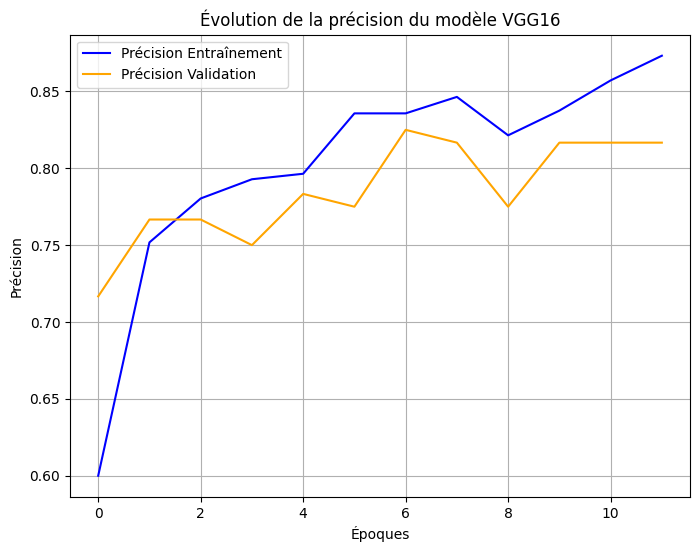

In [ ]:
import matplotlib.pyplot as plt

# Courbe d'évolution de la précision
plt.figure(figsize=(8,6))
plt.plot(history_vgg16.history['accuracy'], label='Précision Entraînement', color='blue')
plt.plot(history_vgg16.history['val_accuracy'], label='Précision Validation', color='orange')
plt.title("Évolution de la précision du modèle VGG16")
plt.xlabel("Époques")
plt.ylabel("Précision")
plt.legend()
plt.grid(True)
plt.show()

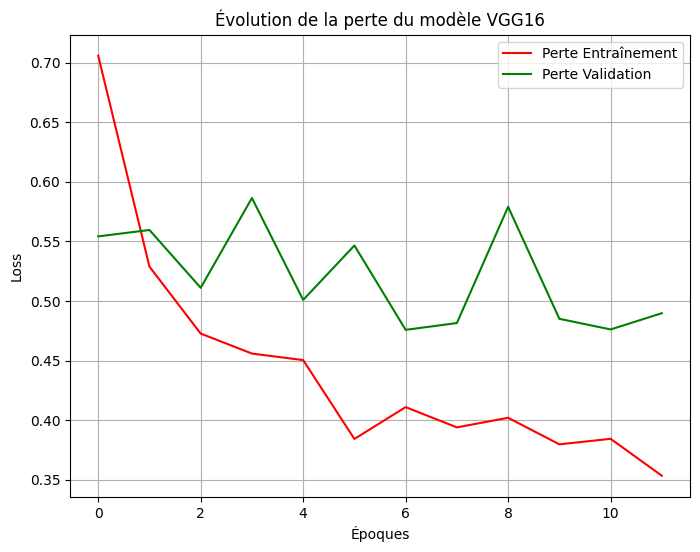

In [ ]:
# === Courbe d'évolution de la perte ===
plt.figure(figsize=(8,6))
plt.plot(history_vgg16.history['loss'], label='Perte Entraînement', color='red')
plt.plot(history_vgg16.history['val_loss'], label='Perte Validation', color='green')
plt.title("Évolution de la perte du modèle VGG16")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 101s 23s/step


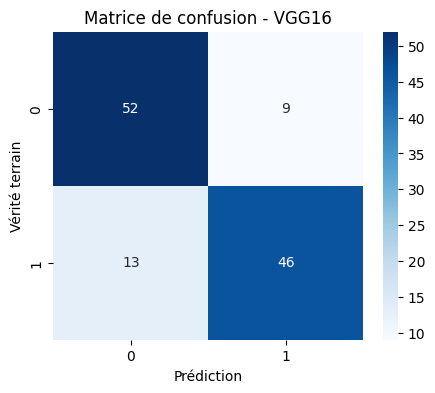


 Rapport de classification :

              precision    recall  f1-score   support

           0       0.80      0.85      0.83        61
           1       0.84      0.78      0.81        59

    accuracy                           0.82       120
   macro avg       0.82      0.82      0.82       120
weighted avg       0.82      0.82      0.82       120



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prédictions sur le jeu de test
y_true = test_generator.classes
y_pred_prob = best_model_vgg16.predict(test_generator, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int)

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title("Matrice de confusion - VGG16")
plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.show()

# Rapport de classification
print("\n Rapport de classification :\n")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


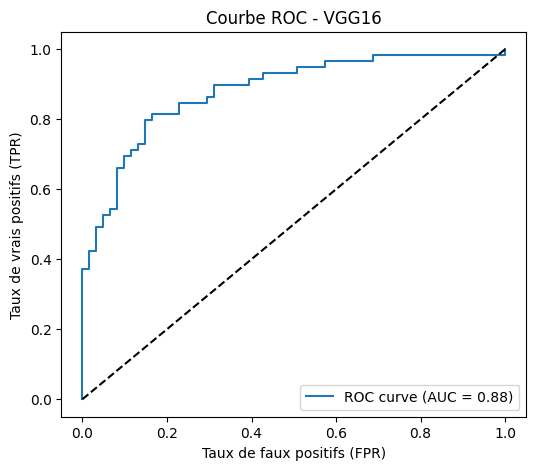

In [ ]:
# Courbe ROC et AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC - VGG16')
plt.legend(loc="lower right")
plt.show()

Entrez un index entre 0 et 799 : 365
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


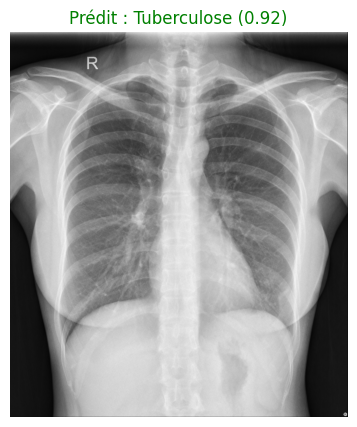

In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Dictionnaire pour les labels
label_dict = {0: "Normal", 1: "Tuberculose"}

#  Chargement du CSV contenant les chemins et labels
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/TB_Dataset/dataset_tb.csv")

# Choisir manuellement une image
idx = int(input(f"Entrez un index entre 0 et {len(df)-1} : "))
if idx < 0 or idx >= len(df):
    print("⚠️ Index invalide. Choisis un nombre dans la plage indiquée.")
else:
    img_path = df.iloc[idx]["path"]
    true_label = int(df.iloc[idx]["label"])

    # Chargement et préparation de l'image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Prédiction du modèle
    pred_prob = best_model_vgg16.predict(img_array)[0][0]
    pred_label = int(np.round(pred_prob))

    # Choisir la couleur
    color = "green" if pred_label == true_label else "red"

    # Affichage
    plt.figure(figsize=(5, 5))
    plt.imshow(image.load_img(img_path), cmap='gray')
    plt.title(
        f"Prédit : {label_dict[pred_label]} ({pred_prob:.2f})",
        color=color,
        fontsize=12
    )
    plt.axis("off")
    plt.show()

#Modèle MobileNetv2

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [ ]:
# Construire le modèle MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model_mobileNet= models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model_mobileNet.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_mobileNet.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/TB_Dataset/best_model_mobilenet.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)


In [ ]:
# --- Entraînement du modèle ---
history_mobilenet = model_mobileNet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5662 - loss: 0.7099
Epoch 1: val_accuracy improved from -inf to 0.70000, saving model to /content/drive/MyDrive/TB_Dataset/best_model_mobilenet.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 166s 9s/step - accuracy: 0.5672 - loss: 0.7091 - val_accuracy: 0.7000 - val_loss: 0.6201 - learning_rate: 1.0000e-04
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6720 - loss: 0.6540
Epoch 2: val_accuracy improved from 0.70000 to 0.73333, saving model to /content/drive/MyDrive/TB_Dataset/best_model_mobilenet.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 148s 8s/step - accuracy: 0.6732 - loss: 0.6519 - val_accuracy: 0.7333 - val_loss: 0.5823 - learning_rate: 1.0000e-04
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7517 - loss: 0.5331
Epoch 3: val_accuracy did not improve from 0.73333
18/18 ━━━━━━━━━━━━━━━━━━━━ 134s 7s/step - accuracy: 0.7509 - loss: 0.5342 - val_accuracy: 0.7167 - val_loss: 0.5553 - learning_rate: 1.0000e-04
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7490 - loss: 0.5097
Epoch 4: val_accuracy did not improve from 0.73333
18/18 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - accuracy: 0.7484 - loss: 0.5101 - val_accuracy: 0.7333 - val_loss: 0.5771 - learning_rate: 1.0000e-04
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7252 - loss: 0.5300
Epoch 5: val_accuracy did not improve from 0.73333
18/18 ━━━━━━━━━━━━━━━━━━━━ 136s 8s/step - accuracy: 0.7260 - loss: 0.5296 - val_accuracy: 0.7250 - val_loss: 0.5530 - learning_rate: 1.0000e-04
Epoch 6/50
18/18 ━━━━━

18/18 ━━━━━━━━━━━━━━━━━━━━ 133s 7s/step - accuracy: 0.7822 - loss: 0.4516 - val_accuracy: 0.7417 - val_loss: 0.5326 - learning_rate: 1.0000e-04
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7728 - loss: 0.4786
Epoch 9: val_accuracy did not improve from 0.74167
18/18 ━━━━━━━━━━━━━━━━━━━━ 132s 7s/step - accuracy: 0.7728 - loss: 0.4786 - val_accuracy: 0.7417 - val_loss: 0.5548 - learning_rate: 1.0000e-04
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7931 - loss: 0.4461
Epoch 10: val_accuracy did not improve from 0.74167
18/18 ━━━━━━━━━━━━━━━━━━━━ 141s 8s/step - accuracy: 0.7934 - loss: 0.4462 - val_accuracy: 0.7417 - val_loss: 0.5304 - learning_rate: 1.0000e-04
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7978 - loss: 0.4565
Epoch 11: val_accuracy improved from 0.74167 to 0.75000, saving model to /content/drive/MyDrive/TB_Dataset/best_model_mobilenet.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 138s 8s/step - accuracy: 0.7976 - loss: 0.4566 - val_accuracy: 0.7500 - val_loss: 0.5404 - learning_rate: 1.0000e-04
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8015 - loss: 0.4318
Epoch 12: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 12: val_accuracy did not improve from 0.75000
18/18 ━━━━━━━━━━━━━━━━━━━━ 132s 7s/step - accuracy: 0.8017 - loss: 0.4315 - val_accuracy: 0.7333 - val_loss: 0.5414 - learning_rate: 1.0000e-04
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8010 - loss: 0.4194
Epoch 13: val_accuracy did not improve from 0.75000
18/18 ━━━━━━━━━━━━━━━━━━━━ 132s 7s/step - accuracy: 0.8012 - loss: 0.4197 - val_accuracy: 0.7417 - val_loss: 0.5357 - learning_rate: 2.0000e-05
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 10.


In [ ]:
from tensorflow.keras.models import load_model

# Chargement du modèle sauvegardé
best_model_mobilenet = load_model('/content/drive/MyDrive/TB_Dataset/best_model_mobilenet.h5')

# Évaluation sur le jeu de test
test_loss, test_acc = best_model_mobilenet.evaluate(test_dataset)
print(f"✅ Test Accuracy : {test_acc:.4f}")
print(f"✅ Test Loss : {test_loss:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.7617 - loss: 0.4949
✅ Test Accuracy : 0.7583
✅ Test Loss : 0.5122


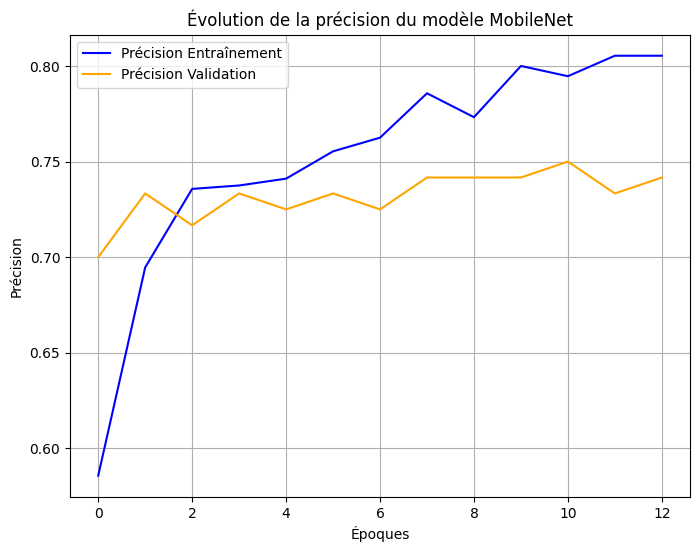

In [ ]:
import matplotlib.pyplot as plt

# Courbe d'évolution de la précision
plt.figure(figsize=(8,6))
plt.plot(history_mobilenet.history['accuracy'], label='Précision Entraînement', color='blue')
plt.plot(history_mobilenet.history['val_accuracy'], label='Précision Validation', color='orange')
plt.title("Évolution de la précision du modèle MobileNet")
plt.xlabel("Époques")
plt.ylabel("Précision")
plt.legend()
plt.grid(True)
plt.show()

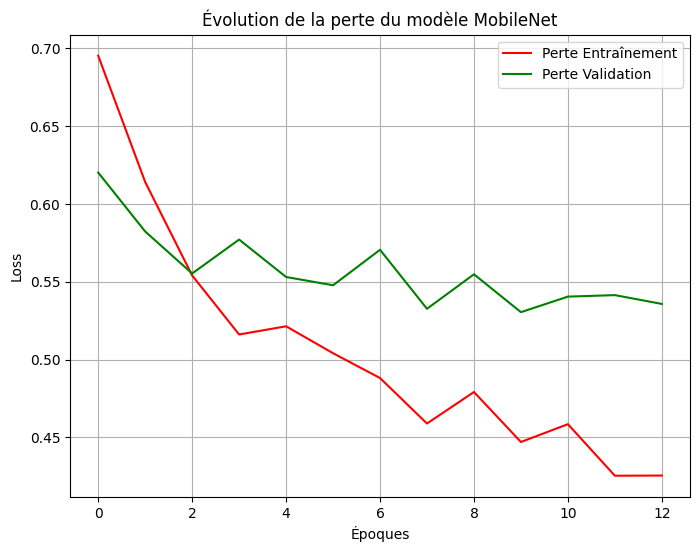

In [ ]:
# === Courbe d'évolution de la perte ===
plt.figure(figsize=(8,6))
plt.plot(history_mobilenet.history['loss'], label='Perte Entraînement', color='red')
plt.plot(history_mobilenet.history['val_loss'], label='Perte Validation', color='green')
plt.title("Évolution de la perte du modèle MobileNet")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

3/4 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step 

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step


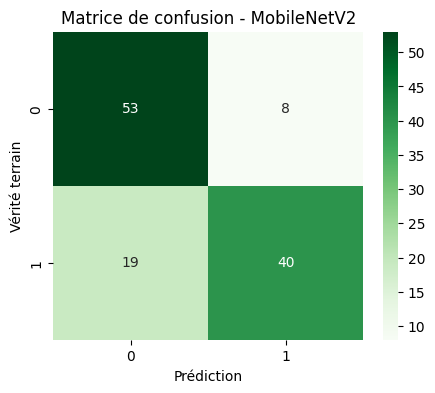


 Rapport de classification MobileNetV2 :

              precision    recall  f1-score   support

           0       0.74      0.87      0.80        61
           1       0.83      0.68      0.75        59

    accuracy                           0.78       120
   macro avg       0.78      0.77      0.77       120
weighted avg       0.78      0.78      0.77       120



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === Prédictions MobileNetV2 ===
y_true = test_generator.classes
y_pred_prob_mob = best_model_mobilenet.predict(test_generator, verbose=1)
y_pred_mob = (y_pred_prob_mob > 0.5).astype(int)

# === Matrice de confusion ===
cm_mob = confusion_matrix(y_true, y_pred_mob)
plt.figure(figsize=(5,4))
sns.heatmap(cm_mob, annot=True, fmt='d', cmap='Greens',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title("Matrice de confusion - MobileNetV2")
plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.show()

# === Rapport de classification ===
print("\n Rapport de classification MobileNetV2 :\n")
print(classification_report(y_true, y_pred_mob, target_names=test_generator.class_indices.keys()))


4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step


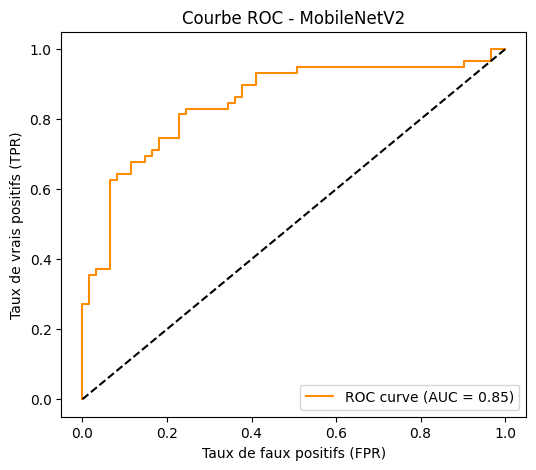

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Prédictions sur le jeu de test pour MobileNetV2
y_true = test_generator.classes
y_pred_prob_mobilenet = best_model_mobilenet.predict(test_generator, verbose=1)

# Calcul de la courbe ROC et de l’AUC
fpr_mobilenet, tpr_mobilenet, thresholds_mobilenet = roc_curve(y_true, y_pred_prob_mobilenet)
roc_auc_mobilenet = auc(fpr_mobilenet, tpr_mobilenet)

# Tracé de la courbe
plt.figure(figsize=(6,5))
plt.plot(fpr_mobilenet, tpr_mobilenet, label=f'ROC curve (AUC = {roc_auc_mobilenet:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC - MobileNetV2')
plt.legend(loc="lower right")
plt.show()

Entrez un index entre 0 et 799 : 365


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


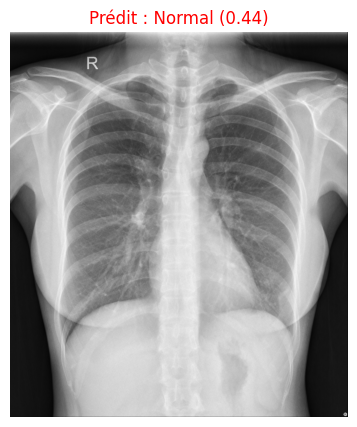

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import pandas as pd

# Dictionnaire des labels
label_dict = {0: "Normal", 1: "Tuberculose"}

# Chargement du CSV contenant les chemins et labels
df = pd.read_csv("/content/drive/MyDrive/TB_Dataset/dataset_tb.csv")

# Choisir manuellement une image
idx = int(input(f"Entrez un index entre 0 et {len(df)-1} : "))
if idx < 0 or idx >= len(df):
    print("⚠️ Index invalide. Choisis un nombre dans la plage indiquée.")
else:
    img_path = df.iloc[idx]["path"]
    true_label = int(df.iloc[idx]["label"])

    # Chargement et préparation de l'image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    #  Prédiction avec MobileNetV2
    pred_prob_mob = best_model_mobilenet.predict(img_array)[0][0]
    pred_label_mob = int(np.round(pred_prob_mob))

    #  Choix de la couleur selon la justesse
    color = "green" if pred_label_mob == true_label else "red"

    #  Affichage du résultat
    plt.figure(figsize=(5, 5))
    plt.imshow(image.load_img(img_path))
    plt.title(
        f"Prédit : {label_dict[pred_label_mob]} ({pred_prob_mob:.2f})",
        color=color,
        fontsize=12
    )
    plt.axis("off")
    plt.show()

#Modèle DenseNetv2

In [ ]:
# === 1. Importations ===
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


In [ ]:
# @title
# === 2. Paramètres ===
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5


In [ ]:
# Charger le CSV contenant les chemins d’images
df = pd.read_csv("/content/drive/MyDrive/TB_Dataset/dataset_tb.csv")

print(f"Nombre total d'images : {len(df)}")
print(df.head())

Nombre total d'images : 800
                                                path  label    source
0  /content/drive/MyDrive/TB_Dataset/Shenzhenset/...      0  Shenzhen
1  /content/drive/MyDrive/TB_Dataset/Shenzhenset/...      0  Shenzhen
2  /content/drive/MyDrive/TB_Dataset/Shenzhenset/...      0  Shenzhen
3  /content/drive/MyDrive/TB_Dataset/Shenzhenset/...      0  Shenzhen
4  /content/drive/MyDrive/TB_Dataset/Shenzhenset/...      0  Shenzhen


In [ ]:
# Construire le modèle DenseNet
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # on gèle les poids du modèle pré-entraîné

model_DenseNet= models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model_DenseNet.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_DenseNet.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,168,833 (27.35 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/TB_Dataset/best_model_densenet.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)


In [ ]:
# --- Entraînement du modèle ---
history_densenet = model_DenseNet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6340 - loss: 0.6707 
Epoch 1: val_accuracy improved from -inf to 0.60833, saving model to /content/drive/MyDrive/TB_Dataset/best_model_densenet.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 251s 14s/step - accuracy: 0.6332 - loss: 0.6705 - val_accuracy: 0.6083 - val_loss: 0.6446 - learning_rate: 1.0000e-04
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.6471 - loss: 0.6396 
Epoch 2: val_accuracy improved from 0.60833 to 0.65833, saving model to /content/drive/MyDrive/TB_Dataset/best_model_densenet.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 235s 13s/step - accuracy: 0.6489 - loss: 0.6380 - val_accuracy: 0.6583 - val_loss: 0.6161 - learning_rate: 1.0000e-04
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7569 - loss: 0.5249 
Epoch 3: val_accuracy improved from 0.65833 to 0.69167, saving model to /content/drive/MyDrive/TB_Dataset/best_model_densenet.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 254s 13s/step - accuracy: 0.7558 - loss: 0.5262 - val_accuracy: 0.6917 - val_loss: 0.5985 - learning_rate: 1.0000e-04
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7674 - loss: 0.5329 
Epoch 4: val_accuracy did not improve from 0.69167
18/18 ━━━━━━━━━━━━━━━━━━━━ 253s 14s/step - accuracy: 0.7664 - loss: 0.5331 - val_accuracy: 0.6750 - val_loss: 0.6057 - learning_rate: 1.0000e-04
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7458 - loss: 0.5619 
Epoch 5: val_accuracy improved from 0.69167 to 0.70000, saving model to /content/drive/MyDrive/TB_Dataset/best_model_densenet.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 240s 13s/step - accuracy: 0.7465 - loss: 0.5603 - val_accuracy: 0.7000 - val_loss: 0.5749 - learning_rate: 1.0000e-04
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7151 - loss: 0.5378 
Epoch 6: val_accuracy improved from 0.70000 to 0.70833, saving model to /content/drive/MyDrive/TB_Dataset/best_model_densenet.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 260s 13s/step - accuracy: 0.7160 - loss: 0.5374 - val_accuracy: 0.7083 - val_loss: 0.6026 - learning_rate: 1.0000e-04
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8024 - loss: 0.4823 
Epoch 7: val_accuracy improved from 0.70833 to 0.72500, saving model to /content/drive/MyDrive/TB_Dataset/best_model_densenet.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 241s 13s/step - accuracy: 0.8020 - loss: 0.4826 - val_accuracy: 0.7250 - val_loss: 0.5634 - learning_rate: 1.0000e-04
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7919 - loss: 0.4614 
Epoch 8: val_accuracy did not improve from 0.72500
18/18 ━━━━━━━━━━━━━━━━━━━━ 229s 13s/step - accuracy: 0.7912 - loss: 0.4624 - val_accuracy: 0.7250 - val_loss: 0.5659 - learning_rate: 1.0000e-04
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7931 - loss: 0.4724 
Epoch 9: val_accuracy improved from 0.72500 to 0.74167, saving model to /content/drive/MyDrive/TB_Dataset/best_model_densenet.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 241s 13s/step - accuracy: 0.7926 - loss: 0.4727 - val_accuracy: 0.7417 - val_loss: 0.5623 - learning_rate: 1.0000e-04
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7551 - loss: 0.5098 
Epoch 10: val_accuracy improved from 0.74167 to 0.75000, saving model to /content/drive/MyDrive/TB_Dataset/best_model_densenet.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 229s 13s/step - accuracy: 0.7557 - loss: 0.5084 - val_accuracy: 0.7500 - val_loss: 0.5502 - learning_rate: 1.0000e-04
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8062 - loss: 0.4267 
Epoch 11: val_accuracy improved from 0.75000 to 0.76667, saving model to /content/drive/MyDrive/TB_Dataset/best_model_densenet.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 267s 13s/step - accuracy: 0.8065 - loss: 0.4272 - val_accuracy: 0.7667 - val_loss: 0.5455 - learning_rate: 1.0000e-04
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7812 - loss: 0.4811 
Epoch 12: val_accuracy did not improve from 0.76667
18/18 ━━━━━━━━━━━━━━━━━━━━ 266s 13s/step - accuracy: 0.7821 - loss: 0.4793 - val_accuracy: 0.7333 - val_loss: 0.6004 - learning_rate: 1.0000e-04
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8143 - loss: 0.4438 
Epoch 13: val_accuracy did not improve from 0.76667
18/18 ━━━━━━━━━━━━━━━━━━━━ 228s 13s/step - accuracy: 0.8136 - loss: 0.4442 - val_accuracy: 0.7417 - val_loss: 0.5438 - learning_rate: 1.0000e-04
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8127 - loss: 0.4436 
Epoch 14: val_accuracy did not improve from 0.76667
18/18 ━━━━━━━━━━━━━━━━━━━━ 235s 13s/step - accuracy: 0.8127 - loss: 0.4430 - val_accuracy: 0.7583 - val_loss: 0.5317 - learning_rate: 1.0000e-04
Epoch 

In [ ]:
from tensorflow.keras.models import load_model

# Chargement du modèle sauvegardé
best_model_densenet = load_model('/content/drive/MyDrive/TB_Dataset/best_model_densenet.h5')

# Évaluation sur le jeu de test
test_loss, test_acc = best_model_densenet.evaluate(test_dataset)
print(f"✅ Test Accuracy : {test_acc:.4f}")
print(f"✅ Test Loss : {test_loss:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 51s 7s/step - accuracy: 0.7246 - loss: 0.5610
✅ Test Accuracy : 0.7333
✅ Test Loss : 0.5625


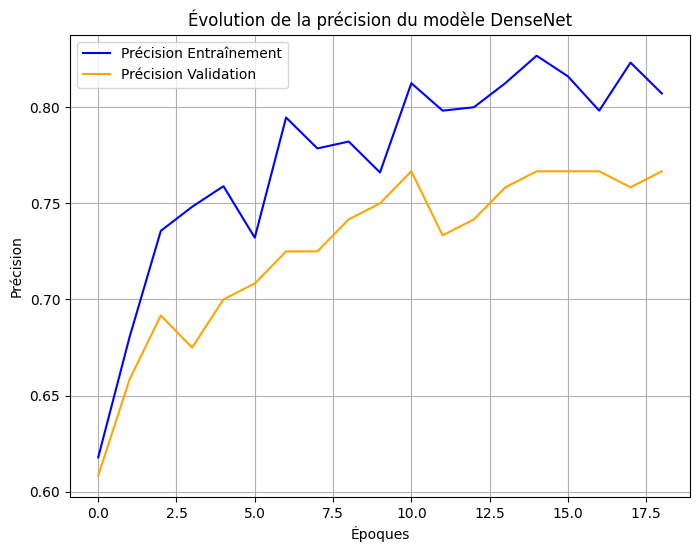

In [ ]:
import matplotlib.pyplot as plt

# Courbe d'évolution de la précision
plt.figure(figsize=(8,6))
plt.plot(history_densenet.history['accuracy'], label='Précision Entraînement', color='blue')
plt.plot(history_densenet.history['val_accuracy'], label='Précision Validation', color='orange')
plt.title("Évolution de la précision du modèle DenseNet")
plt.xlabel("Époques")
plt.ylabel("Précision")
plt.legend()
plt.grid(True)
plt.show()

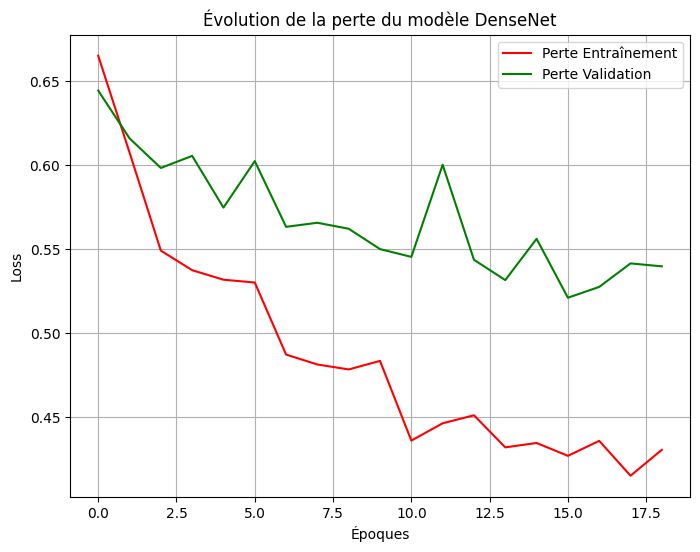

In [ ]:
# === Courbe d'évolution de la perte ===
plt.figure(figsize=(8,6))
plt.plot(history_densenet.history['loss'], label='Perte Entraînement', color='red')
plt.plot(history_densenet.history['val_loss'], label='Perte Validation', color='green')
plt.title("Évolution de la perte du modèle DenseNet")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 55s 12s/step


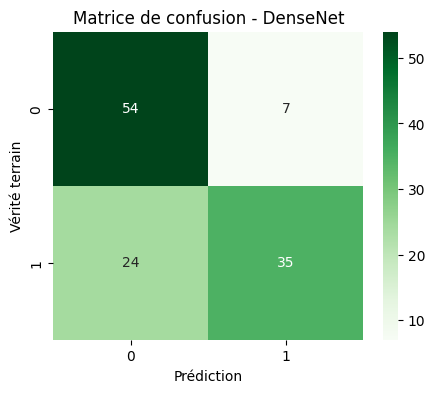


📊 Rapport de classification DenseNet :

              precision    recall  f1-score   support

           0       0.69      0.89      0.78        61
           1       0.83      0.59      0.69        59

    accuracy                           0.74       120
   macro avg       0.76      0.74      0.74       120
weighted avg       0.76      0.74      0.74       120



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === Prédictions DenseNet ===
y_true = test_generator.classes
y_pred_prob_dens = best_model_densenet.predict(test_generator, verbose=1)
y_pred_dens = (y_pred_prob_dens > 0.5).astype(int)

# === Matrice de confusion ===
cm_dens = confusion_matrix(y_true, y_pred_dens)
plt.figure(figsize=(5,4))
sns.heatmap(cm_dens, annot=True, fmt='d', cmap='Greens',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title("Matrice de confusion - DenseNet")
plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.show()

# === Rapport de classification ===
print("\n📊 Rapport de classification DenseNet :\n")
print(classification_report(y_true, y_pred_dens, target_names=test_generator.class_indices.keys()))

4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step


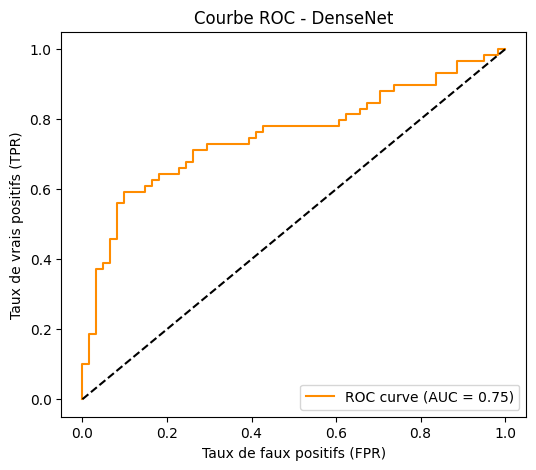

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Prédictions sur le jeu de test pour DenseNet
y_true = test_generator.classes
y_pred_prob_densenet = best_model_densenet.predict(test_generator, verbose=1)

# Calcul de la courbe ROC et de l’AUC
fpr_densenet, tpr_densenet, thresholds_densenet = roc_curve(y_true, y_pred_prob_densenet)
roc_auc_densenet = auc(fpr_densenet, tpr_densenet)

# Tracé de la courbe
plt.figure(figsize=(6,5))
plt.plot(fpr_densenet, tpr_densenet, label=f'ROC curve (AUC = {roc_auc_densenet:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC - DenseNet')
plt.legend(loc="lower right")
plt.show()

Entrez un index entre 0 et 799 : 365
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


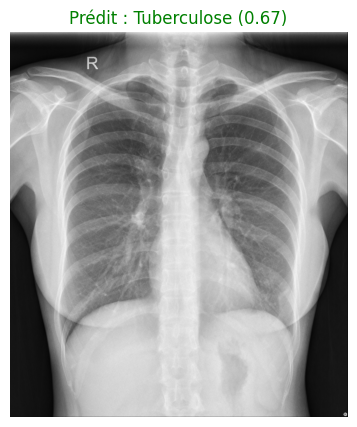

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import pandas as pd

# Dictionnaire des labels
label_dict = {0: "Normal", 1: "Tuberculose"}

# Chargement du CSV contenant les chemins et labels
df = pd.read_csv("/content/drive/MyDrive/TB_Dataset/dataset_tb.csv")

# Choisir manuellement une image
idx = int(input(f"Entrez un index entre 0 et {len(df)-1} : "))
if idx < 0 or idx >= len(df):
    print("⚠️ Index invalide. Choisis un nombre dans la plage indiquée.")
else:
    img_path = df.iloc[idx]["path"]
    true_label = int(df.iloc[idx]["label"])

    # Chargement et préparation de l'image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    #  Prédiction avec DenseNet
    y_pred_prob_densenet = best_model_densenet.predict(img_array)[0][0]
    pred_label_dens = int(np.round(y_pred_prob_densenet))

    #  Choix de la couleur selon la justesse
    color = "green" if pred_label_dens == true_label else "red"

    #  Affichage du résultat
    plt.figure(figsize=(5, 5))
    plt.imshow(image.load_img(img_path))
    plt.title(
        f"Prédit : {label_dict[pred_label_dens]} ({y_pred_prob_densenet:.2f})",
        color=color,
        fontsize=12
    )
    plt.axis("off")
    plt.show()